# Welcome to the Beginner Hackathon! 🌾 🦗
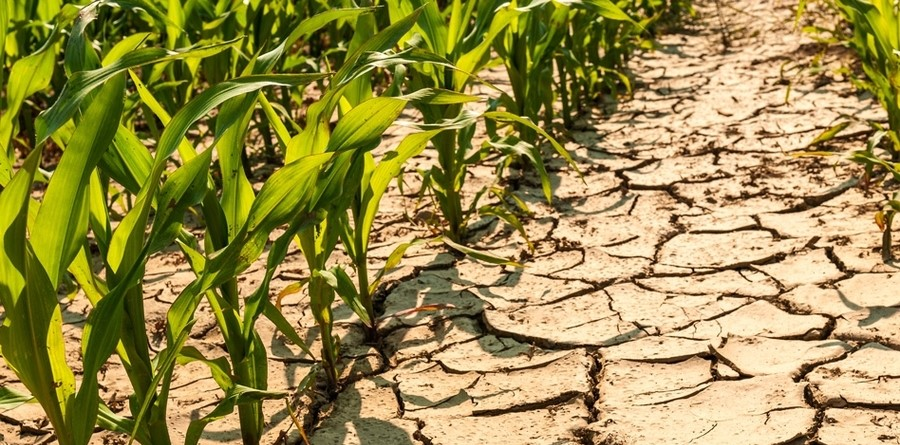

In this starter notebook, you will learn some basic data cleaning and preparation methods as well as how to build your first Neural Network. We begin by mounting the drive and getting our environment set up.

In [ ]:
!pip install pandas numpy scikit-learn torch torcheval

In [ ]:
import os
import urllib.request
from datetime import datetime
from pathlib import Path

import pandas as pd
import torch
import torch.optim as optim
from torch import nn

First let's download the data

In [ ]:
# Create the directory if it doesn't exist
os.makedirs("data/beginner", exist_ok=True)

# X is for input, Y is for labels
files = ["x_test.csv", "x_train.csv", "x_val.csv", "y_train.csv", "y_val.csv"]

base_url = (
    "https://github.com/BioGeek/hackathon_indabaX_2024/releases/download/v1.0-beginner/"
)

# Download files if they don't exist
for file in files:
    file_path = f"data/beginner/{file}"
    if not os.path.exists(file_path):
        print(f"Downloading {file}...")
        urllib.request.urlretrieve(f"{base_url}{file}", file_path)
    else:
        print(f"{file} already exists, skipping download.")

### Dataset preparation 📊

We'll be using *pandas* (a common package that is used for data manipulation) to load in and read the dataset. We've already split the data into Training and Test files so all we need to do is load them into two separate dataframes.

The x variables are the inputs to our model and the y variables are our desired outputs. We load in both the training and test datasets. Our datasets do have some NaNs and are also replaced with zeros.


In [ ]:
beginner_data_path = Path("data/beginner")

X_train = pd.read_csv(beginner_data_path / "x_train.csv")
Y_train = pd.read_csv(beginner_data_path / "y_train.csv")

X_val = pd.read_csv(beginner_data_path / "x_val.csv")
Y_val = pd.read_csv(beginner_data_path / "y_val.csv")

X_test = pd.read_csv(beginner_data_path / "x_test.csv")

Let's take a look into the dataset

In [ ]:
variables = [c for c in X_train.columns if c not in ("label", "ID")]
print(f"We have {len(variables)} variables: {', '.join(variables)}.")
print(
    f"We have {len(X_train)} samples in our training dataset and {len(X_val)} samples in our validation dataset"
)

As we can see, our data contains `NaN`s, we replace those with negative one.

In [ ]:
X_train = X_train.fillna(-1)
X_val = X_val.fillna(-1)
X_test = X_test.fillna(-1)

Our variables also have values ranging from incredibly small bounds to incredibly large. We will normalize these. We also need to remove the sample IDs since these do not form part of the x variables or the y variables.

In [ ]:
# store the test IDs for the submission file
test_ID = X_test["ID"]


def normalize(df):
    normalized_df = (df - df.mean()) / df.std()
    return normalized_df.to_numpy(dtype="float32")


X_train = X_train.drop(columns=["ID"])
X_train = normalize(X_train)

Y_train = Y_train.drop(columns=["ID"])
Y_train = Y_train.to_numpy(dtype="float32")

X_val = X_val.drop(columns=["ID"])
X_val = normalize(X_val)

Y_val = Y_val.drop(columns=["ID"])
Y_val = Y_val.to_numpy(dtype="float32")

X_test = X_test.drop(columns=["ID"])
X_test = normalize(X_test)

### Dataloaders ⚡

We need some sort of mechanism to pass data into our model. We can do this via a Dataloader. After we build this, we can simply pass our datasets into the dataloader and it'll take care of sending samples to our model for us!

In [ ]:
# The dataloader, tensor conversions etc


class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    # Get sample
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [ ]:
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

### Building the model 🏗️

We can now build a neural network. We can vary some of the parameters below but not all of them. In `BinaryClassificationModel`, we can vary all the `hidden` layers, the number of layers as well as the activation functions.
Feel free to play around with these parameters! You can also add/ delete layers too!

In [ ]:
# Neural network


class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(109, 200, bias=True),
            nn.ReLU(),  # Non-linear layer
            nn.Linear(200, 300, bias=True),
            nn.ReLU(),
            nn.Linear(300, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 1, bias=True),
            nn.Sigmoid(),  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.layers(x)

### Train the model ⏰


It can be instructive to try some variations on this optimization scheme:

Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?

Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do your results differ?

In [ ]:
lr = 0.001  # learning rate
n_epochs = 10  # how many times to loop over the data

In [ ]:
model = BinaryClassificationModel()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

* Gets a batch of training data from the DataLoader

* Zeros the optimizer’s gradients

* Performs an inference - that is, gets predictions from the model for an input batch

* Calculates the loss for that set of predictions vs. the labels on the dataset

* Calculates the backward gradients over the learning weights

* Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

In [ ]:
def train_one_epoch():
    total_loss = 0.0
    num_batches = 0

    for data in train_loader:
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data
        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    return average_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
epoch_number = 0

best_vloss = float("inf")

for epoch in range(n_epochs):
    print(f"EPOCH {epoch_number + 1}:")

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)

    # Log the running loss averaged per batch
    # for both training and validation
    print(f"Training loss: {avg_loss:.2%}, Validation loss: {avg_vloss:.2%}")

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch = epoch_number + 1
        model_path = f"model_{timestamp}_{best_epoch}.pt"
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

# After training is complete, print out the best model information
print(
    f"Best model saved as  'model_{timestamp}_{best_epoch}.pt' with validation loss: {best_vloss:.2%}"
)

### Predicting on the test set

Now that we have our model, let's get some test-set predictions...

In [ ]:
# Load the best model
best_model_path = f"model_{timestamp}_{best_epoch}.pt"
best_model = BinaryClassificationModel()
best_model.load_state_dict(torch.load(best_model_path))

# Convert the test set to a tensor
X_test_tensor = torch.from_numpy(X_test)

# Make predictions on the test set
best_model.eval()
with torch.no_grad():
    test_predictions = best_model(X_test_tensor)

# Convert the predictions to numpy array
test_predictions = test_predictions.detach().numpy()

# Print the predictions
print(test_predictions)

### Get your output into submission format 📅

We need to get our outputs into their "camera-ready" form. Luckily we already have the function to do this. Just alter the line `submission = submit(outputs, test_ID, 'Beginner' )` with your name and you should be good to go!

In [ ]:
def submit(test_predictions, ID, your_name):
    # Convert the predictions to binary
    threshold = 0.5
    binary_predictions = (test_predictions > threshold).astype(int)

    # Create a DataFrame with binary_predictions and test_ID
    df = pd.DataFrame({"ID": test_ID, "Target": binary_predictions.ravel()})

    filename = f"{your_name}_submission.csv"
    df.to_csv(filename, index=False)
    print(f"Saved submission to {filename}")

In [ ]:
submit(test_predictions, test_ID, "beginner")

Now upload your submission to Zindi, check your score on the hidden test set, and see your ranking on the leaderboard!